# Predicting Employee Compensation

## Data Dictionary
<br>**Year Type** - Fiscal (July through June) or Calendar (January through December)
<br>**Year** - An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012.
<br>**Organization Group Code** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,Fire, Adult Probation, District Attorney, and Sheriff.
<br> **Organization Group** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,
Fire, Adult Probation, District Attorney, and Sheriff.
<br>**Department Code** - Departments are the primary organizational unit used by the Cityand County of San Francisco. Examples include Recreation and
Parks, Public Works, and the Police Department.
<br>**Department Code** - Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
<br>**Union Code** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Union** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Job Family Code** Job Family combines similar Jobs into meaningful groups.
<br>**Job Family** Job Family combines similar Jobs into meaningful groups.
<br>**Employee Identifier** Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the
Employee Compensation report hosted on openbook.sfgov.org,
but that report does show one row for each employee. Employee
ID has been included here to allow users to reconstruct the
original report. Note that each employee’s identifier will change
each time this dataset is updated, so comparisons by employee
across multiple versions of the dataset are not possible.
<br>**Salaries** - Normal salaries paid to permanent or temporary City employees.
<br>**Overtime** - Amounts paid to City employees working in excess of 40 hours
per week.
<br>**Other Salaries** - Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments. Total Salary Number The sum of all salaries paid to City employees.
<br>**Retirement** City contributions to employee retirement plans.
<br>**Health/Dental** City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
<br>**Other Benefits** Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment
insurance premiums, and minor discretionary benefits not included in the above categories.
<br>**Total Benefits** The sum of all benefits paid to City employees.
<br>**Total Compensation** The sum of all salaries and benefits paid to City employees.

Read the data and answer the following questions to predict employee compensation

### Read Data

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import isnull, when, count, col,avg
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
 
sc = SparkContext.getOrCreate()
spark = SparkSession(sc) 

In [4]:
file_location = "Employee_Compensation.csv"
file_type = "csv"

# CSV options
infer_schema = True
first_row_is_header = True
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
rawDF = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [5]:
# number of rows and columns in the dataset
print("Number of Rows: ", rawDF.count())
print("Number of Columns", len(rawDF.columns))

Number of Rows:  291825
Number of Columns 22


In [6]:
# check the datatype of the variables
rawDF.printSchema()

root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: integer (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: double (nullable = true)
 |-- Overtime: double (nullable = true)
 |-- Other Salaries: double (nullable = true)
 |-- Total Salary: double (nullable = true)
 |-- Retirement: double (nullable = true)
 |-- Health/Dental: double (nullable = true)
 |-- Other Benefits: double (nullable = true)
 |-- Total Benefits: double (nullable = true)
 |-- Total Compensation: double (nullable = true)



### Q. Convert the incorrect column type into its suitable column type

In [9]:
rawDF.show(5,False)

+---------+----+-----------------------+--------------------+---------------+------------------------------+----------+---------------------------------+---------------+-----------------------------+--------+---------------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|Organization Group  |Department Code|Department                    |Union Code|Union                            |Job Family Code|Job Family                   |Job Code|Job                        |Employee Identifier|Salaries |Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+------------------------------+----------+---------------------------------+---------------+-----------------------------+--------+---------------------------+--------

all the data types look appropriate, no type change needed

### Q. Check basic statistics and perform necessary changes

In [10]:
rawDF.describe().show()

+-------+---------+-----------------+-----------------------+--------------------+---------------+-------------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|Year Type|             Year|Organization Group Code|  Organization Group|Department Code|         Department|       Union Code|               Union|   Job Family Code|          Job Family|          Job Code|               Job|Employee Identifier|         Salaries|          Overtime|   Other Salaries|     Total Salary|        Retirement|    Health/Dental|   Other Benefits|    Total Benefits|Total Compensation|
+-------+---------+-----------------+-----------------------+--------------------+---------------+-------------------+-----------------+--------------------

### Q. Perform Missing Value Analysis

In [11]:
from pyspark.sql.functions import isnull, when, count, col
rawDF.select([count(when(isnull(c), c)).alias(c) for c in rawDF.columns]).show()

+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|Organization Group|Department Code|Department|Union Code|Union|Job Family Code|Job Family|Job Code|Job|Employee Identifier|Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|        0|   0|                      0|                 0|              0|         0|        43|   43|             45|        45|       0|  0|     

The columns 'Union Code','Union', 'Job Family Code','Job Family' have missing values. Let's drop those records

In [12]:
rawDF = rawDF.na.drop()

In [13]:
rawDF.select([count(when(isnull(c), c)).alias(c) for c in rawDF.columns]).show()

+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|Organization Group|Department Code|Department|Union Code|Union|Job Family Code|Job Family|Job Code|Job|Employee Identifier|Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|        0|   0|                      0|                 0|              0|         0|         0|    0|              0|         0|       0|  0|     

In [14]:
rawDF.count()

291780

45 records are removed

### Exploratory Data Analysis

#### Q. Find top compensating organizations. Display using bar plot

In [27]:
pandasDF = rawDF.select('Organization Group','Total Compensation').groupBy('Organization Group').sum('Total Compensation').orderBy('sum(Total Compensation)',ascending=False).toPandas()

In [29]:
pandasDF.set_index('Organization Group', inplace=True)

<AxesSubplot:xlabel='Organization Group'>

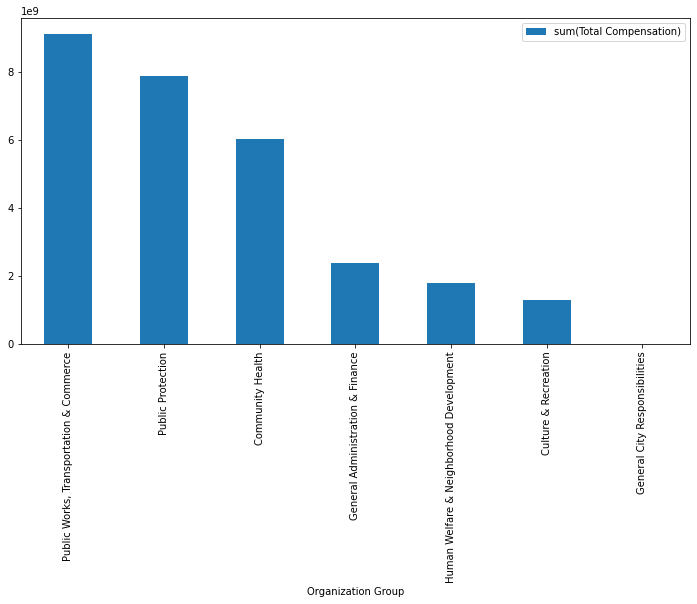

In [30]:
pandasDF.plot(kind='bar',figsize=(12,6))

#### Q. Find top Compensating Jobs. Display using bar plot

In [31]:
pandasDF = rawDF.select('Job Family','Total Compensation').groupBy('Job Family').sum('Total Compensation').orderBy('sum(Total Compensation)',ascending=False).toPandas()

In [32]:
pandasDF.set_index('Job Family', inplace=True)

<AxesSubplot:xlabel='Job Family'>

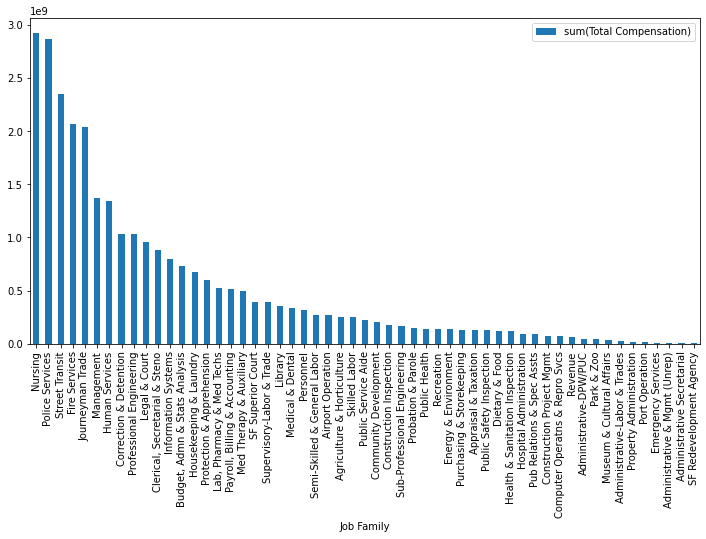

In [33]:
pandasDF.plot(kind='bar',figsize=(12,6))

#### Q. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

In [34]:
from pyspark.ml.stat import Correlation

In [35]:
pandasDF = rawDF.toPandas()

In [36]:
pandasDF.shape

(291780, 22)

In [37]:
pandasDF.corr()

,Year,Organization Group Code,Union Code,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Year,1.000000,-0.005502,-0.003870,0.000862,0.005596,0.016248,-0.016795,0.005757,0.015601,-0.011778,0.031127,0.012670,0.007576
Organization Group Code,-0.005502,1.000000,-0.006996,0.003382,-0.216651,-0.302762,-0.228144,-0.283139,-0.246128,-0.232404,0.025132,-0.205479,-0.269099
Union Code,-0.003870,-0.006996,1.000000,-0.002607,-0.048412,0.060528,0.171653,-0.003255,-0.066981,-0.073378,-0.281951,-0.123989,-0.033241
Employee Identifier,0.000862,0.003382,-0.002607,1.000000,-0.002981,-0.001174,-0.002249,-0.003130,-0.001747,-0.001865,-0.000092,-0.001582,-0.002804
Salaries,0.005596,-0.216651,-0.048412,-0.002981,1.000000,0.271207,0.324293,0.960506,0.952715,0.774705,0.696823,0.937994,0.972599
Overtime,0.016248,-0.302762,0.060528,-0.001174,0.271207,1.000000,0.348200,0.495423,0.313345,0.312241,0.061962,0.287554,0.453014
Other Salaries,-0.016795,-0.228144,0.171653,-0.002249,0.324293,0.348200,1.000000,0.498609,0.340722,0.210699,0.039663,0.268855,0.450834
Total Salary,0.005757,-0.283139,-0.003255,-0.003130,0.960506,0.495423,0.498609,1.000000,0.931432,0.759804,0.614889,0.902778,0.994301
Retirement,0.015601,-0.246128,-0.066981,-0.001747,0.952715,0.313345,0.340722,0.931432,1.000000,0.794544,0.670117,0.965301,0.956965
Health/Dental,-0.011778,-0.232404,-0.073378,-0.001865,0.774705,0.312241,0.210699,0.759804,0.794544,1.000000,0.599472,0.889630,0.805964


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

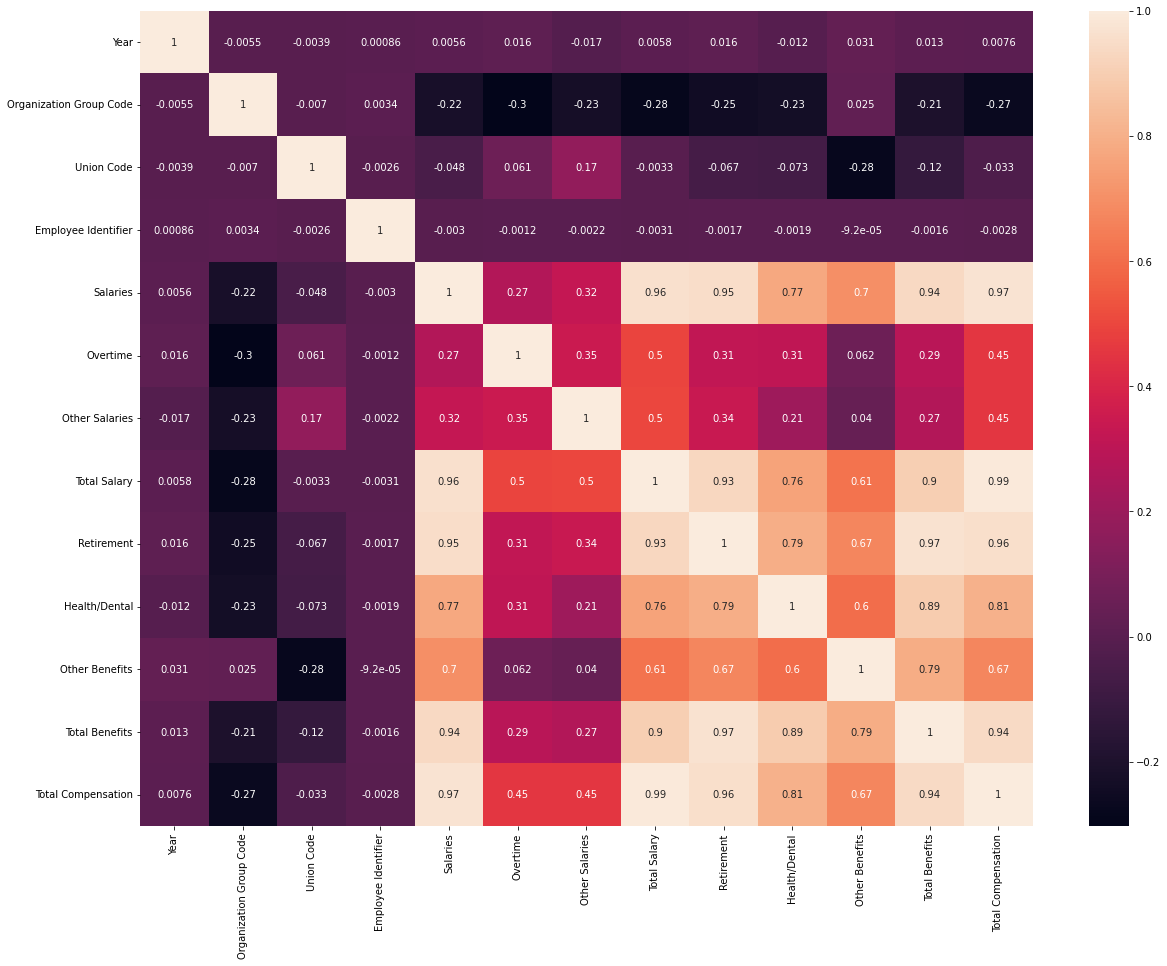

In [43]:
plt.figure(figsize=(20,15))
sns.heatmap(pandasDF.corr(),annot=True)
plt.show()

Total Compensation depends on Salaries, Total Salary, Retirement, Health/Dental, Other Benefits, Total Benefits, Overtime, Other Salaries. Target variable doesn't show correlation with Year, Organization Group Code, Union COde and Employee Identifier

### Q. Perform necessary data pre-processing and divide the data into train and test set

In [44]:
from pyspark.ml.feature import VectorAssembler

In [46]:
vectorAssembler = VectorAssembler(inputCols = ['Salaries', 'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits', 'Overtime', 'Other Salaries'], outputCol = 'features')
vrawDF = vectorAssembler.transform(rawDF)
vrawDF = vrawDF.select(['features', 'Total Compensation'])
vrawDF.show(3)

+--------------------+------------------+
|            features|Total Compensation|
+--------------------+------------------+
|[114473.16,115973...|         159436.65|
|[84077.11,84077.1...|         120054.05|
|[9980.17,10778.6,...|          13868.64|
+--------------------+------------------+
only showing top 3 rows



In [47]:
splits = vrawDF.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Q. Fit Linear Regression model on the data and check its performance

In [48]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Total Compensation', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.4959347031576209,0.370950360638972,1.2061447931124671,0.2654358080406223,0.4544018125712607,0.5136020864917162,0.6006478328388928,0.6019504236203728]
Intercept: 1448.524296816471


In [49]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 2042.727919
r2: 0.999091


In [50]:
train_df.describe().show()

+-------+------------------+
|summary|Total Compensation|
+-------+------------------+
|  count|            203922|
|   mean| 98119.29168309462|
| stddev|  67745.6979166169|
|    min|         -74082.61|
|    max|         653498.15|
+-------+------------------+



In [51]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Total Compensation","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Total Compensation",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|Total Compensation|            features|
+------------------+------------------+--------------------+
|1673.3074536264476|            259.29|(8,[0,1,2,5],[259...|
|1550.0602343230005|            115.24|(8,[0,1,4,5],[99....|
|1542.8600339987277|             107.9|(8,[0,1,4,5],[100...|
|1542.8600339987277|             107.9|(8,[0,1,4,5],[100...|
|1590.0279025898562|            161.85|(8,[0,1,4,5],[150...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.999105


In [52]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 2029.74


In [53]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5000000000000002, 0.39217552893084534, 0.10465820028512114, 0.03176475980739723, 0.01280323805822457, 0.005503951431343633, 0.00488923587143362, 0.001289995904074576, 0.0006893747399656517, 0.0004753052695012903, 0.000458697572103252]
+-------------------+
|          residuals|
+-------------------+
| -1436.569244396043|
|-1327.7280645147175|
|-1966.0810048087774|
|-1441.7418454465899|
|-1439.9919005922065|
|-1438.3506197616493|
|-1436.2697236605231|
|-1434.4309669562442|
|-1431.5691282747966|
|-1431.5691282747966|
|-1431.5691282747966|
|-1431.5688083137875|
|-1430.2805393051617|
|-1429.5343288716306|
|-1428.1775826288467|
|-1428.1775826288467|
| -1417.344913683069|
|-1427.5158232218182|
| -1424.786036982897|
|-1403.3258094040668|
+-------------------+
only showing top 20 rows



### Q. Fit Decision Tree Regression model on the data and check its performance

In [54]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Total Compensation')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="Total Compensation", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 7143.18


In [55]:
dt_model.featureImportances

SparseVector(8, {0: 0.0001, 1: 0.9944, 4: 0.0013, 5: 0.0043})

most important feature is Total Salary

### Fit Gradient Boosted Tree Regression model on the data and check its performance 

In [61]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Total Compensation', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'Total Compensation', 'features').show(5)

+------------------+------------------+--------------------+
|        prediction|Total Compensation|            features|
+------------------+------------------+--------------------+
|1257.0562695275567|            259.29|(8,[0,1,2,5],[259...|
|1257.0562695275567|            115.24|(8,[0,1,4,5],[99....|
|1257.0562695275567|             107.9|(8,[0,1,4,5],[100...|
|1257.0562695275567|             107.9|(8,[0,1,4,5],[100...|
|1257.0562695275567|            161.85|(8,[0,1,4,5],[150...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [62]:
gbt_evaluator = RegressionEvaluator(
    labelCol="Total Compensation", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4910.54


### Q Compare each model performance and tell which model performs better

LinearRegression performed the best on the given data